## 1. Initial Inspection
### 🧾 What It Does

* Iterates over each Excel file in both bus and subway folders.

* Reads all sheets in each file (some files have multiple sheets).

* Prints:

    *1.* Folder name (Bus/Subway) <br>
    *2.* File name <br>
    *3.* Sheet name <br>
    *4.* Number of rows/columns (shape) <br>
    *5.* Column names and their inferred data types

In [3]:
import os
import pandas as pd

# Define base folder
base_path = "."

# Define subfolders for bus and subway
folders = ["bus", "subway"]

for folder in folders:
    folder_path = os.path.join(base_path, folder)
    print(f"\n{'='*100}")
    print(f"Inspecting folder: {folder_path}")
    print(f"{'='*100}\n")

    # Loop through all Excel files in the folder
    for file in os.listdir(folder_path):
        if file.endswith((".xlsx", ".xls")):
            file_path = os.path.join(folder_path, file)
            print(f"\n{'-'*80}")
            print(f"📘 File: {file}")
            print(f"{'-'*80}")

            # Read all sheets
            xls = pd.ExcelFile(file_path)
            for sheet_name in xls.sheet_names:
                df = pd.read_excel(xls, sheet_name=sheet_name, nrows=5)  # only top rows for speed
                print(f"\nSheet: {sheet_name}")
                print(f"Shape: {df.shape}")
                print("Columns and Data Types:")
                print(df.dtypes)
                print("\n")


Inspecting folder: .\bus


--------------------------------------------------------------------------------
📘 File: ttc-bus-delay-data-2020.xlsx
--------------------------------------------------------------------------------

Sheet: Jan 2020
Shape: (5, 10)
Columns and Data Types:
Report Date    datetime64[ns]
Route                   int64
Time                   object
Day                    object
Location               object
Incident               object
Delay                   int64
Gap                     int64
Direction              object
Vehicle               float64
dtype: object



Sheet: Feb 2020
Shape: (5, 10)
Columns and Data Types:
Report Date    datetime64[ns]
Route                   int64
Time                   object
Day                    object
Location               object
Incident               object
Delay                   int64
Gap                     int64
Direction              object
Vehicle                 int64
dtype: object



Sheet: March 2020
Shape: (5,

## 2. Merge Excel Files
### 🧾 What It Does

* Scans *data_raw/bus/* and *data_raw/subway/*

* Reads all Excel files & sheets

* Standardizes column names to a canonical schema (handles your variants like Report Date vs Date, Route vs Line, Direction vs Bound, Location vs Station, Min Delay vs Delay, Min Gap vs Gap, Incident vs Code, etc.)

* Parses a combined timestamp

* Concats per mode (Bus/Subway) separately

* Saves: data_processed/bus_merged.csv and data_processed/subway_merged.csv

* Prints a compact processing log

In [5]:
import os
from pathlib import Path
import pandas as pd
import numpy as np

BASE = Path(".")
BUS_DIR = BASE / "bus"
SUBWAY_DIR = BASE / "subway"
OUT_DIR = Path("data_processed")
OUT_DIR.mkdir(exist_ok=True)

# ---------- helpers
def first_present(cols_set, candidates):
    """Return first matching column name from candidates (case-insensitive search over cols_set)."""
    for c in candidates:
        lc = c.lower()
        if lc in cols_set:
            return lc
    return None

def unify_columns(df, mode, src_file, src_sheet):
    """
    Standardize columns for bus or subway.
    Returns a new DataFrame with canonical columns and types.
    """
    df = df.copy()
    df.columns = [str(c).strip() for c in df.columns]
    lower_map = {c.lower(): c for c in df.columns}
    cols_lower = set(lower_map.keys())

    # Common candidates across modes
    cand_date     = ["report date", "date"]
    cand_time     = ["time"]
    cand_day      = ["day"]
    cand_delay    = ["min delay", "delay"]
    cand_gap      = ["min gap", "gap"]
    cand_vehicle  = ["vehicle"]

    # Mode-specific candidates (but we’ll cross-map gracefully)
    if mode == "bus":
        cand_route_or_line = ["route", "line"]  # bus sometimes uses Line (2025)
        cand_dir_or_bound  = ["direction", "bound"]
        cand_loc_or_stn    = ["location", "station"]
        cand_incident_code_or_text = ["incident", "code"]  # code showed up in 2025 bus
    else:  # subway
        cand_route_or_line = ["line", "route"]  # subway usually 'Line'
        cand_dir_or_bound  = ["bound", "direction"]
        cand_loc_or_stn    = ["station", "location"]
        cand_incident_code_or_text = ["code", "incident"]  # subway usually 'Code'

    # Pick actual column names found
    date_col   = first_present(cols_lower, cand_date)
    time_col   = first_present(cols_lower, cand_time)
    day_col    = first_present(cols_lower, cand_day)
    route_col  = first_present(cols_lower, cand_route_or_line)
    dir_col    = first_present(cols_lower, cand_dir_or_bound)
    loc_col    = first_present(cols_lower, cand_loc_or_stn)
    inc_col    = first_present(cols_lower, cand_incident_code_or_text)
    delay_col  = first_present(cols_lower, cand_delay)
    gap_col    = first_present(cols_lower, cand_gap)
    veh_col    = first_present(cols_lower, cand_vehicle)

    # Build a new frame with canonical names
    out = pd.DataFrame()

    if date_col:
        out["date"] = pd.to_datetime(df[lower_map[date_col]], errors="coerce")
    else:
        out["date"] = pd.NaT

    if time_col:
        out["time"] = df[lower_map[time_col]].astype(str)
    else:
        out["time"] = pd.NA

    # Combine date + time into a single timestamp (when both exist)
    if date_col and time_col:
        out["reported_at"] = pd.to_datetime(
            out["date"].dt.strftime("%Y-%m-%d") + " " + out["time"],
            errors="coerce"
        )
    else:
        out["reported_at"] = pd.NaT

    if day_col:
        out["day"] = df[lower_map[day_col]].astype(str)
    else:
        out["day"] = pd.NA

    # Route/Line unified as 'route' for BUS, and 'line' for SUBWAY
    if route_col:
        series_route = df[lower_map[route_col]]
        # normalize to string (some months int64/float64)
        series_route = series_route.astype(str).str.strip()
    else:
        series_route = pd.Series(pd.NA, index=df.index, dtype="object")

    if mode == "bus":
        out["route"] = series_route
        out["line"] = pd.NA  # not used for bus, but keep column for compatibility if needed
    else:
        out["line"] = series_route
        out["route"] = pd.NA  # not used for subway

    # Direction/Bound unified into 'direction' (BUS) or 'bound' (SUBWAY) but keep both for compatibility
    if dir_col:
        series_dir = df[lower_map[dir_col]].astype(str).str.strip()
    else:
        series_dir = pd.Series(pd.NA, index=df.index, dtype="object")

    if mode == "bus":
        out["direction"] = series_dir
        out["bound"] = pd.NA
    else:
        out["bound"] = series_dir
        out["direction"] = pd.NA

    # Location/Station unified, but keep both for cross-compatibility
    if loc_col:
        series_loc = df[lower_map[loc_col]].astype(str).str.strip()
    else:
        series_loc = pd.Series(pd.NA, index=df.index, dtype="object")

    if mode == "bus":
        out["location"] = series_loc
        out["station"] = pd.NA
    else:
        out["station"] = series_loc
        out["location"] = pd.NA

    # Incident text vs Code unified
    if inc_col:
        series_inc = df[lower_map[inc_col]].astype(str).str.strip()
        # If the source column name suggests a code, populate 'incident_code', else 'incident'
        if inc_col == "code":
            out["incident_code"] = series_inc
            out["incident"] = pd.NA
        elif inc_col == "incident":
            out["incident"] = series_inc
            out["incident_code"] = pd.NA
        else:
            # Fallback: attempt to infer from values; otherwise store in 'incident'
            out["incident"] = series_inc
            out["incident_code"] = pd.NA
    else:
        out["incident"] = pd.NA
        out["incident_code"] = pd.NA

    # Delay & Gap minutes
    def to_int64_nullable(s):
        return pd.to_numeric(s, errors="coerce").astype("Int64")

    if delay_col:
        out["minutes_delay"] = to_int64_nullable(df[lower_map[delay_col]])
    else:
        out["minutes_delay"] = pd.Series(pd.array([pd.NA]*len(df), dtype="Int64"))

    if gap_col:
        out["minutes_gap"] = to_int64_nullable(df[lower_map[gap_col]])
    else:
        out["minutes_gap"] = pd.Series(pd.array([pd.NA]*len(df), dtype="Int64"))

    # Vehicle
    if veh_col:
        out["vehicle"] = to_int64_nullable(df[lower_map[veh_col]])
    else:
        out["vehicle"] = pd.Series(pd.array([pd.NA]*len(df), dtype="Int64"))

    # Provenance
    out["source_file"] = src_file
    out["source_sheet"] = src_sheet
    out["mode"] = mode

    # Return consistent column order per mode
    CANONICAL_ORDER_BUS = [
        "mode","source_file","source_sheet",
        "date","time","reported_at","day",
        "route","direction","location",
        "incident","incident_code",
        "minutes_delay","minutes_gap",
        "vehicle","line","bound","station"
    ]
    CANONICAL_ORDER_SUBWAY = [
        "mode","source_file","source_sheet",
        "date","time","reported_at","day",
        "line","bound","station",
        "incident_code","incident",
        "minutes_delay","minutes_gap",
        "vehicle","route","direction","location"
    ]
    order = CANONICAL_ORDER_BUS if mode=="bus" else CANONICAL_ORDER_SUBWAY
    for col in order:
        if col not in out.columns:
            out[col] = pd.NA
    return out[order]

def process_folder(folder: Path, mode: str) -> pd.DataFrame:
    assert mode in ("bus","subway")
    frames = []
    print(f"\n{'='*100}\nProcessing {mode.upper()} in {folder}\n{'='*100}")
    for fname in sorted(os.listdir(folder)):
        if not fname.lower().endswith((".xlsx",".xls")):
            continue
        fpath = folder / fname
        try:
            xls = pd.ExcelFile(fpath)
        except Exception as e:
            print(f"!! ERROR opening {fname}: {e}")
            continue
        for sh in xls.sheet_names:
            try:
                df = pd.read_excel(xls, sheet_name=sh)
                std = unify_columns(df, mode=mode, src_file=fname, src_sheet=sh)
                frames.append(std)
                print(f"OK: {fname} :: {sh} -> {len(df):,} rows")
            except Exception as e:
                print(f"!! ERROR reading {fname} :: {sh}: {e}")
    if frames:
        merged = pd.concat(frames, ignore_index=True)
    else:
        merged = pd.DataFrame()
    print(f"TOTAL {mode.upper()} rows: {len(merged):,}")
    return merged

# ---------- run
bus_merged = process_folder(BUS_DIR, mode="bus")
subway_merged = process_folder(SUBWAY_DIR, mode="subway")

# Optional: basic sanity fixes — e.g., negative delays to NA, absurdly large to NA
def clean_minutes(df, col, max_minutes=1440):
    s = pd.to_numeric(df[col], errors="coerce").astype("Int64")
    s = s.mask(s < 0).mask(s > max_minutes)
    df[col] = s
    return df

if not bus_merged.empty:
    bus_merged = clean_minutes(bus_merged, "minutes_delay")
    bus_merged = clean_minutes(bus_merged, "minutes_gap")
    # Ensure strings trimmed
    for c in ["route","direction","location","incident","incident_code"]:
        bus_merged[c] = bus_merged[c].astype("string").str.strip()
    bus_out = OUT_DIR / "bus_merged.csv"
    bus_merged.to_csv(bus_out, index=False)
    print(f"Saved -> {bus_out} ({len(bus_merged):,} rows)")

if not subway_merged.empty:
    subway_merged = clean_minutes(subway_merged, "minutes_delay")
    subway_merged = clean_minutes(subway_merged, "minutes_gap")
    for c in ["line","bound","station","incident","incident_code"]:
        subway_merged[c] = subway_merged[c].astype("string").str.strip()
    sub_out = OUT_DIR / "subway_merged.csv"
    subway_merged.to_csv(sub_out, index=False)
    print(f"Saved -> {sub_out} ({len(subway_merged):,} rows)")

# Quick peek
print("\nBUS columns:", list(bus_merged.columns) if not bus_merged.empty else [])
print("SUBWAY columns:", list(subway_merged.columns) if not subway_merged.empty else [])


Processing BUS in bus
OK: ttc-bus-delay-data-2020.xlsx :: Jan 2020 -> 4,282 rows
OK: ttc-bus-delay-data-2020.xlsx :: Feb 2020 -> 4,077 rows
OK: ttc-bus-delay-data-2020.xlsx :: March 2020 -> 3,922 rows
OK: ttc-bus-delay-data-2020.xlsx :: April 2020 -> 3,864 rows
OK: ttc-bus-delay-data-2020.xlsx :: May 2020 -> 3,504 rows
OK: ttc-bus-delay-data-2020.xlsx :: June 2020 -> 3,001 rows
OK: ttc-bus-delay-data-2020.xlsx :: July 2020 -> 2,210 rows
OK: ttc-bus-delay-data-2020.xlsx :: Aug 20 -> 2,093 rows
OK: ttc-bus-delay-data-2020.xlsx :: Sept 20 -> 1,768 rows
OK: ttc-bus-delay-data-2020.xlsx :: Oct 20 -> 2,019 rows
OK: ttc-bus-delay-data-2020.xlsx :: Nov 20 -> 2,575 rows
OK: ttc-bus-delay-data-2020.xlsx :: Dec 20 -> 2,836 rows
OK: ttc-bus-delay-data-2021.xlsx :: Jan 21 -> 2,832 rows
OK: ttc-bus-delay-data-2021.xlsx :: Feb 21 -> 2,874 rows
OK: ttc-bus-delay-data-2021.xlsx :: Mar 21 -> 4,845 rows
OK: ttc-bus-delay-data-2021.xlsx :: April -> 4,442 rows
OK: ttc-bus-delay-data-2021.xlsx :: May -> 4,

## 3. Data Cleaning & Feature Engineering
### 🧹 Data Cleaning

1. Missing & Invalid Data Handling
    * Reconstructs missing timestamps (_safe_dt_parse(date, time)). <br>
    * Replaces invalid delay/gap values (_clean_minutes) with NA. <br>
    * Ensures consistent types (Int64, string, datetime). <br>
    * Removes duplicates with _dedup(). <br>
    * Drops rows missing essential identifying fields.
<br><br>
2. String Normalization
    * Trims whitespace and standardizes capitalization (_strip_str, _title_str). <br>
    * Standardizes direction labels (E/W/N/S → Eastbound/Westbound/...). <br>
    * Cleans and harmonizes text fields like route, location, line, station. <br>
<br>
3. Incident Categorization
    * Preserves the original (incident_raw). <br>
    * Produces a cleaned, categorized version (incident_norm). <br>
    * Uses regex-based keyword buckets for consistency across free-text reports. <br>
<br>
4. Consistency & Integrity
    * Ensures all timestamps are timezone-naive and comparable. <br>
    * Reconciles column naming differences between Bus and Subway datasets. <br>
    * Creates standard column order for downstream analysis.

---
### ⚙️ Feature Engineering

1. Temporal Features
   Created via _derive_time_parts(): <br>
    * year, month, month_name
    * day, dow_index, dow_name
    * hour, is_weekend
    * peak_period (AM/PM/Off-Peak) — categorical time-of-day feature
<br><br>
2. Categorical Normalization
    * Standardized direction/bound and route/line/location columns to unified naming. <br>
    * Ensures month_name and dow_name have ordered categories — crucial for time series plots or Tableau visuals. <br>
<br>
3. Unified Schema (Long Table)
    * Combines both modes (bus/subway) into ttc_all_clean_long.csv — standardized for cross-mode analysis or dashboards. <br>
    * Columns renamed to generic, mode-agnostic names: <br>
        route_or_line, dir_or_bound, loc_or_station, incident_text.

In [10]:
import pandas as pd
import numpy as np
from pathlib import Path
import re

IN_DIR  = Path("data_processed")
OUT_DIR = Path("data_processed")
OUT_DIR.mkdir(exist_ok=True)

# ------------ Utilities
def _to_nullable_int(s):
    return pd.to_numeric(s, errors="coerce").astype("Int64")

def _strip_str(s):
    return s.astype("string").str.strip()

def _title_str(s):
    return s.astype("string").str.strip().str.title()

def _safe_dt_parse(date_series, time_series=None):
    """Combine date + time (if time exists) into a single datetime; fallback to just date."""
    d = pd.to_datetime(date_series, errors="coerce", utc=True)
    if time_series is not None:
        t = time_series.astype("string").str.strip()
        combo = pd.to_datetime(d.dt.strftime("%Y-%m-%d") + " " + t, errors="coerce", utc=True)
        combo = combo.fillna(pd.to_datetime(d.dt.strftime("%Y-%m-%d") + " 12:00:00", errors="coerce", utc=True))
        combo = combo.dt.tz_localize(None)  # remove UTC for consistency
        return combo
    return d.dt.tz_localize(None)

def _clean_minutes(series, max_minutes=1440):
    s = pd.to_numeric(series, errors="coerce").astype("Int64")
    s = s.mask(s < 0)            # drop negatives
    s = s.mask(s > max_minutes)  # drop > max_minutes as invalid
    return s

def _derive_time_parts(df, ts_col="reported_at"):
    ts = df[ts_col]
    df["year"]       = ts.dt.year.astype("Int64")
    df["month"]      = ts.dt.month.astype("Int64")
    df["month_name"] = ts.dt.month_name()
    df["day"]        = ts.dt.day.astype("Int64")
    df["dow_index"]  = ts.dt.dayofweek.astype("Int64")   
    df["dow_name"]   = ts.dt.day_name()
    df["hour"]       = ts.dt.hour.astype("Int64")
    df["is_weekend"] = df["dow_index"].isin([5,6])

    # Handle nullable ints safely
    am_peak = df["hour"].between(7, 9, inclusive="both").fillna(False)
    pm_peak = df["hour"].between(16, 18, inclusive="both").fillna(False)

    df["peak_period"] = pd.Categorical(
        np.select(
            [am_peak, pm_peak],
            ["AM Peak","PM Peak"],
            default="Off-Peak"
        ),
        categories=["AM Peak","PM Peak","Off-Peak"],
        ordered=True
    )
    return df

def _normalize_incident_text(s):
    base = s.astype("string").str.strip().str.lower()

    def map_one(x):
        if not isinstance(x, str): return x
        # keyword buckets
        if re.search(r"mechan|bus defect|br(ea)?k ?down|engine|tire|door", x): return "Mechanical"
        if re.search(r"collision|accident|crash|struck", x): return "Collision"
        if re.search(r"medical|injur|sick|ill", x): return "Medical"
        if re.search(r"security|assault|disturb|trespass|police|law", x): return "Security/Police"
        if re.search(r"signal|switch|track|overhead|infrastruct|construction|work", x): return "Infrastructure/Signal"
        if re.search(r"weather|snow|ice|storm|flood|heat", x): return "Weather"
        if re.search(r"operat|operator|crew|staff|shortage", x): return "Operations/Staffing"
        if re.search(r"schedule|gap|headway|late|hold", x): return "Schedule/Headway"
        if re.search(r"diversion|detour|route change", x): return "Diversion/Detour"
        return x

    mapped = base.map(map_one)
    mapped = mapped.astype("string").str.replace(r"\s+", " ", regex=True).str.strip().str.title()
    return mapped

def _standardize_direction(values):
    s = values.astype("string").str.strip()
    s_low = s.str.lower()
    s_std = s.copy()

    s_std = np.where(s_low.isin(["e","east","eb","eastbound"]), "Eastbound", s_std)
    s_std = np.where(s_low.isin(["w","west","wb","westbound"]), "Westbound", s_std)
    s_std = np.where(s_low.isin(["n","north","nb","northbound"]), "Northbound", s_std)
    s_std = np.where(s_low.isin(["s","south","sb","southbound"]), "Southbound", s_std)
    return pd.Series(s_std, index=values.index, dtype="string")

def _dedup(df, subset_cols):
    before = len(df)
    df = df.drop_duplicates(subset=subset_cols, keep="first")
    after = len(df)
    print(f"De-duplicated {before - after} rows using {subset_cols}")
    return df

# ------------ Load
bus = pd.read_csv(IN_DIR/"bus_merged.csv", low_memory=False, parse_dates=["date","reported_at"])
sub = pd.read_csv(IN_DIR/"subway_merged.csv", low_memory=False, parse_dates=["date","reported_at"])

# Ensure 'time' column exists
for d in (bus, sub):
    if "time" not in d.columns:
        d["time"] = pd.NA
    d["time"] = d["time"].astype("string").str.strip()

# ------------ BUS cleaning
bus["reported_at"] = pd.to_datetime(bus["reported_at"], errors="coerce")
bus_missing_ts = bus["reported_at"].isna()
if bus_missing_ts.any():
    bus.loc[bus_missing_ts, "reported_at"] = _safe_dt_parse(bus.loc[bus_missing_ts, "date"], bus.loc[bus_missing_ts, "time"])

# Normalize key fields
for c in ["route","direction","location","incident","incident_code","line","bound","station","day"]:
    if c in bus.columns:
        bus[c] = _strip_str(bus[c])

bus["route"] = bus["route"].fillna(bus.get("line", pd.NA))
bus["direction"] = bus["direction"].fillna(bus.get("bound", pd.NA))
bus["location"] = bus["location"].fillna(bus.get("station", pd.NA))

# Incident normalization
bus["incident_raw"] = bus["incident"]
bus["incident_norm"] = _normalize_incident_text(bus["incident"].fillna(""))

# Clean minutes
bus["minutes_delay"] = _clean_minutes(bus["minutes_delay"], max_minutes=240)
bus["minutes_gap"]   = _clean_minutes(bus["minutes_gap"],   max_minutes=240)

# Direction standardization
bus["direction"] = _standardize_direction(bus["direction"]).fillna(bus["direction"])

# Vehicle as nullable int
bus["vehicle"] = _to_nullable_int(bus["vehicle"])

# Drop invalid rows
bus = bus[~bus["reported_at"].isna()]
bus = bus[ bus[["route","location","incident","incident_code"]].notna().any(axis=1) ]

# Deduplicate
bus = _dedup(bus, subset_cols=["reported_at","route","location","incident","incident_code","vehicle"])

# Ensure proper datetime dtype
bus["reported_at"] = pd.to_datetime(bus["reported_at"], errors="coerce").dt.tz_localize(None)

# Enrich time fields
bus = _derive_time_parts(bus, "reported_at")

# Save clean BUS
bus_cols_order = [
    "mode","source_file","source_sheet",
    "reported_at","date","time","year","month","month_name","day","dow_index","dow_name","hour","is_weekend","peak_period",
    "route","direction","location",
    "incident_raw","incident_norm","incident_code",
    "minutes_delay","minutes_gap","vehicle"
]
bus_clean = bus.copy()
for c in bus_cols_order:
    if c not in bus_clean.columns:
        bus_clean[c] = pd.NA
bus_clean = bus_clean[bus_cols_order].sort_values(["reported_at","route"]).reset_index(drop=True)
bus_clean_path = OUT_DIR/"bus_clean.csv"
bus_clean.to_csv(bus_clean_path, index=False)
print(f"Saved BUS clean -> {bus_clean_path} ({len(bus_clean):,} rows)")

# ------------ SUBWAY cleaning
sub["reported_at"] = pd.to_datetime(sub["reported_at"], errors="coerce")
sub_missing_ts = sub["reported_at"].isna()
if sub_missing_ts.any():
    sub.loc[sub_missing_ts, "reported_at"] = _safe_dt_parse(sub.loc[sub_missing_ts, "date"], sub.loc[sub_missing_ts, "time"])

for c in ["line","bound","station","incident","incident_code","route","direction","location","day"]:
    if c in sub.columns:
        sub[c] = _strip_str(sub[c])

sub["line"]    = sub["line"].fillna(sub.get("route", pd.NA))
sub["bound"]   = sub["bound"].fillna(sub.get("direction", pd.NA))
sub["station"] = sub["station"].fillna(sub.get("location", pd.NA))

sub["incident_raw"] = sub["incident"]
sub["incident_norm"] = _normalize_incident_text(sub["incident"].fillna(""))

sub["minutes_delay"] = _clean_minutes(sub["minutes_delay"], max_minutes=360)
sub["minutes_gap"]   = _clean_minutes(sub["minutes_gap"],   max_minutes=360)

sub["bound"] = _standardize_direction(sub["bound"]).fillna(sub["bound"])
sub["vehicle"] = _to_nullable_int(sub["vehicle"])

sub = sub[~sub["reported_at"].isna()]
sub = sub[ sub[["line","station","incident","incident_code"]].notna().any(axis=1) ]

sub = _dedup(sub, subset_cols=["reported_at","line","station","incident","incident_code","vehicle"])

# Ensure datetime dtype
sub["reported_at"] = pd.to_datetime(sub["reported_at"], errors="coerce").dt.tz_localize(None)

sub = _derive_time_parts(sub, "reported_at")

# Save clean SUBWAY
sub_cols_order = [
    "mode","source_file","source_sheet",
    "reported_at","date","time","year","month","month_name","day","dow_index","dow_name","hour","is_weekend","peak_period",
    "line","bound","station",
    "incident_raw","incident_norm","incident_code",
    "minutes_delay","minutes_gap","vehicle"
]
sub_clean = sub.copy()
for c in sub_cols_order:
    if c not in sub_clean.columns:
        sub_clean[c] = pd.NA
sub_clean = sub_clean[sub_cols_order].sort_values(["reported_at","line"]).reset_index(drop=True)
sub_clean_path = OUT_DIR/"subway_clean.csv"
sub_clean.to_csv(sub_clean_path, index=False)
print(f"Saved SUBWAY clean -> {sub_clean_path} ({len(sub_clean):,} rows)")

# ------------ UNIFIED LONG TABLE
bus_long = bus_clean.rename(columns={
    "route":"route_or_line","direction":"dir_or_bound","location":"loc_or_station",
    "incident_norm":"incident_text"
})[[
    "mode","reported_at","date","time","year","month","month_name","day","dow_index","dow_name","hour","is_weekend","peak_period",
    "route_or_line","dir_or_bound","loc_or_station","incident_text","incident_code",
    "minutes_delay","minutes_gap","vehicle","source_file","source_sheet"
]]

sub_long = sub_clean.rename(columns={
    "line":"route_or_line","bound":"dir_or_bound","station":"loc_or_station",
    "incident_norm":"incident_text"
})[[
    "mode","reported_at","date","time","year","month","month_name","day","dow_index","dow_name","hour","is_weekend","peak_period",
    "route_or_line","dir_or_bound","loc_or_station","incident_text","incident_code",
    "minutes_delay","minutes_gap","vehicle","source_file","source_sheet"
]]

all_long = pd.concat([bus_long, sub_long], ignore_index=True)
all_long["mode"] = all_long["mode"].astype("category")
all_long["month_name"] = pd.Categorical(
    all_long["month_name"],
    categories=["January","February","March","April","May","June","July","August","September","October","November","December"],
    ordered=True
)
all_long["dow_name"] = pd.Categorical(
    all_long["dow_name"],
    categories=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],
    ordered=True
)

all_out = OUT_DIR/"ttc_all_clean_long.csv"
all_long.to_csv(all_out, index=False)
print(f"Saved UNIFIED long -> {all_out} ({len(all_long):,} rows)")

# ------------ Quick sanity report
def quick_report(df, label):
    print(f"\n=== {label} ===")
    print("Rows:", len(df))
    print("Time range:", df['reported_at'].min(), "→", df['reported_at'].max())
    print("Null % minutes_delay:", (df['minutes_delay'].isna().mean()*100).round(2), "%")
    print("Null % incident_text:", (df.get('incident_text', pd.Series([np.nan]*len(df))).isna().mean()*100).round(2), "%")
    print("Top incident categories:")
    print(df.get('incident_text', pd.Series([], dtype='object')).value_counts(dropna=True).head(10))

quick_report(bus_clean, "BUS CLEAN")
quick_report(sub_clean, "SUBWAY CLEAN")
quick_report(all_long, "ALL LONG (Tableau)")


C:\Users\khush\AppData\Local\Temp\ipykernel_15168\4030549498.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  combo = pd.to_datetime(d.dt.strftime("%Y-%m-%d") + " " + t, errors="coerce", utc=True)


De-duplicated 1612 rows using ['reported_at', 'route', 'location', 'incident', 'incident_code', 'vehicle']
Saved BUS clean -> data_processed\bus_clean.csv (292,250 rows)
De-duplicated 146 rows using ['reported_at', 'line', 'station', 'incident', 'incident_code', 'vehicle']
Saved SUBWAY clean -> data_processed\subway_clean.csv (117,742 rows)
Saved UNIFIED long -> data_processed\ttc_all_clean_long.csv (409,992 rows)

=== BUS CLEAN ===
Rows: 292250
Time range: 2020-01-01 00:01:00 → 2025-08-31 23:51:00
Null % minutes_delay: 0.95 %
Null % incident_text: 100.0 %
Top incident categories:
Series([], Name: count, dtype: int64)

=== SUBWAY CLEAN ===
Rows: 117742
Time range: 2020-01-01 01:18:00 → 2025-08-31 23:29:00
Null % minutes_delay: 0.01 %
Null % incident_text: 100.0 %
Top incident categories:
Series([], Name: count, dtype: int64)

=== ALL LONG (Tableau) ===
Rows: 409992
Time range: 2020-01-01 00:01:00 → 2025-08-31 23:51:00
Null % minutes_delay: 0.68 %
Null % incident_text: 0.0 %
Top inciden

### 📈 Outputs (for Analytics)
* bus_clean.csv → Bus data, cleaned + engineered.
* subway_clean.csv → Subway data, cleaned + engineered.
* ttc_all_clean_long.csv → Unified dataset for BI tools (Tableau, Power BI, etc.).

---
## 4. Data Quality Assessment / Data Profiling
This Data Quality Assessment provides: <br>
* Date coverage: start/end dates and daily activity counts (highlights any missing periods).
* Missingness rates: % of missing for key fields (route/line, station/location, incident, minutes_delay).
* Distribution insights: share of 0-minute vs ≥60-minute delays to detect outliers or recording issues.
* Top categories: most frequent incident types, routes/lines, and problem locations.
* Anomaly samples: small extracts of zero-delay or unusually long-delay events for manual review.

In [11]:
import pandas as pd
import numpy as np
from pathlib import Path

IN_DIR  = Path("data_processed")
OUT_DIR = IN_DIR / "quality"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------- Load
bus = pd.read_csv(IN_DIR/"bus_clean.csv", low_memory=False, parse_dates=["reported_at","date"])
sub = pd.read_csv(IN_DIR/"subway_clean.csv", low_memory=False, parse_dates=["reported_at","date"])
all_long = pd.read_csv(IN_DIR/"ttc_all_clean_long.csv", low_memory=False, parse_dates=["reported_at","date"])

datasets = {
    "bus": bus,
    "subway": sub,
    "all_long": all_long
}

# ---------- Helpers
def column_profile(df: pd.DataFrame) -> pd.DataFrame:
    """Per-column type, non-null, null%, unique, example, min/max for numeric/datetime."""
    rows = []
    for c in df.columns:
        s = df[c]
        nn = s.notna().sum()
        nu = s.nunique(dropna=True)
        dtype = str(s.dtype)
        example = s.dropna().iloc[0] if nn else np.nan
        mn = mx = ""
        if pd.api.types.is_numeric_dtype(s):
            mn, mx = pd.to_numeric(s, errors="coerce").min(), pd.to_numeric(s, errors="coerce").max()
        elif pd.api.types.is_datetime64_any_dtype(s):
            mn, mx = s.min(), s.max()
        rows.append({
            "column": c,
            "dtype": dtype,
            "non_null": int(nn),
            "null": int(df.shape[0]-nn),
            "null_pct": round((1 - nn/len(df))*100, 2) if len(df) else 0.0,
            "unique": int(nu),
            "min": mn,
            "max": mx,
            "example_value": example,
        })
    return pd.DataFrame(rows).sort_values("column")

def dataset_overview(df: pd.DataFrame, name: str, ts_col="reported_at") -> pd.DataFrame:
    rows = []
    n = len(df)
    dup_all = df.duplicated().sum()
    # basic NA rates for key fields if present
    key_cols = [c for c in ["reported_at","minutes_delay","minutes_gap","incident","incident_code",
                            "route","direction","location","line","bound","station","incident_text"] if c in df.columns]
    na_rates = {f"na_%_{c}": round(df[c].isna().mean()*100, 2) for c in key_cols}
    # time coverage
    tmin = df[ts_col].min() if ts_col in df.columns else pd.NaT
    tmax = df[ts_col].max() if ts_col in df.columns else pd.NaT
    # zero/near-zero delays
    z_delays = int((pd.to_numeric(df.get("minutes_delay", pd.Series(dtype="Int64")), errors="coerce") == 0).sum()) if "minutes_delay" in df.columns else 0
    hi_delays = int((pd.to_numeric(df.get("minutes_delay", pd.Series(dtype="Int64")), errors="coerce") >= 60).sum()) if "minutes_delay" in df.columns else 0

    rows.append({
        "dataset": name,
        "rows": n,
        "cols": df.shape[1],
        "duplicates_exact": int(dup_all),
        "time_min": tmin,
        "time_max": tmax,
        "zero_min_delay_rows": z_delays,
        "ge_60_min_delay_rows": hi_delays,
        **na_rates
    })
    return pd.DataFrame(rows)

def daily_coverage(df: pd.DataFrame, ts_col="reported_at") -> pd.DataFrame:
    if ts_col not in df.columns or df[ts_col].isna().all():
        return pd.DataFrame(columns=["date","rows"])
    day = df[ts_col].dt.floor("D")
    g = (day.to_frame("date")
            .assign(rows=1)
            .groupby("date", as_index=False)["rows"].sum()
            .sort_values("date"))
    return g

def top_counts(df: pd.DataFrame, col: str, k=20) -> pd.DataFrame:
    if col not in df.columns:
        return pd.DataFrame(columns=[col,"count"])
    vc = (df[col]
          .dropna()
          .astype(str)
          .str.strip()
          .value_counts()
          .head(k)
          .rename_axis(col)
          .reset_index(name="count"))
    return vc

def anomaly_samples(df: pd.DataFrame, mode: str) -> dict:
    """Collect a few rows to inspect quickly: missing keys, zero-delay but incident present, very long delays."""
    out = {}
    if "minutes_delay" in df.columns:
        zero = df[(pd.to_numeric(df["minutes_delay"], errors="coerce")==0)]
        longd = df[(pd.to_numeric(df["minutes_delay"], errors="coerce")>=60)]
        out["zero_delay_head"] = zero.head(10)
        out["long_delay_head"] = longd.head(10)
    # missing “place” or “route/line”
    place_cols = [c for c in ["location","station","loc_or_station"] if c in df.columns]
    id_cols = [c for c in ["route","line","route_or_line"] if c in df.columns]
    miss_place = df[df[place_cols].isna().all(axis=1)] if place_cols else df.iloc[0:0]
    miss_id = df[df[id_cols].isna().all(axis=1)] if id_cols else df.iloc[0:0]
    out["missing_place_head"] = miss_place.head(10)
    out["missing_id_head"] = miss_id.head(10)
    return out

# ---------- Run profiles and export
all_overviews = []
with pd.ExcelWriter(OUT_DIR/"data_quality_workbook.xlsx", engine="xlsxwriter") as xw:
    for name, df in datasets.items():
        print(f"\n=== Profiling: {name} ===")
        # Overview
        ov = dataset_overview(df, name)
        all_overviews.append(ov)
        ov.to_excel(xw, sheet_name=f"{name}_overview", index=False)
        ov.to_csv(OUT_DIR/f"{name}__overview.csv", index=False)

        # Column profile
        cp = column_profile(df)
        cp.to_excel(xw, sheet_name=f"{name}_columns", index=False)
        cp.to_csv(OUT_DIR/f"{name}__column_profile.csv", index=False)

        # Daily coverage
        dc = daily_coverage(df)
        dc.to_excel(xw, sheet_name=f"{name}_daily_counts", index=False)
        dc.to_csv(OUT_DIR/f"{name}__daily_counts.csv", index=False)

        # Top categories (pick sensible columns if present)
        tops = {}
        for col in ["incident_text","incident_norm","incident","incident_code",
                    "route","line","route_or_line",
                    "location","station","loc_or_station",
                    "dow_name","month_name","peak_period","hour"]:
            if col in df.columns:
                tops[col] = top_counts(df, col, k=20)
                tops[col].to_excel(xw, sheet_name=f"{name}_top_{col[:20]}", index=False)
                tops[col].to_csv(OUT_DIR/f"{name}__top_{col}.csv", index=False)

        # Anomaly samples (write to Excel only)
        an = anomaly_samples(df, name)
        for key, sample in an.items():
            if not sample.empty:
                sample.to_excel(xw, sheet_name=f"{name}_{key}", index=False)

# Combined overview
combined_overview = pd.concat(all_overviews, ignore_index=True)
combined_overview.to_csv(OUT_DIR/"_combined_overview.csv", index=False)

print("\nSaved outputs to:", OUT_DIR.resolve())
print("  - data_quality_workbook.xlsx (multiple sheets)")
print("  - *_overview.csv, *_column_profile.csv, *_daily_counts.csv, *_top_*.csv")
print("\nQuick glance:\n", combined_overview)


=== Profiling: bus ===

=== Profiling: subway ===

=== Profiling: all_long ===

Saved outputs to: C:\Users\khush\Desktop\project_root\data_raw\data_processed\quality
  - data_quality_workbook.xlsx (multiple sheets)
  - *_overview.csv, *_column_profile.csv, *_daily_counts.csv, *_top_*.csv

Quick glance:
     dataset    rows  cols  duplicates_exact            time_min  \
0       bus  292250    24                 0 2020-01-01 00:01:00   
1    subway  117742    24                 0 2020-01-01 01:18:00   
2  all_long  409992    23                 0 2020-01-01 00:01:00   

             time_max  zero_min_delay_rows  ge_60_min_delay_rows  \
0 2025-08-31 23:51:00                22982                  8384   
1 2025-08-31 23:29:00                70806                   386   
2 2025-08-31 23:51:00                93788                  8770   

   na_%_reported_at  na_%_minutes_delay  na_%_minutes_gap  na_%_incident_code  \
0               0.0                0.95              1.07              

## 5. EDA Storyline & Deliverables
### A. Core KPIs:
1. Total Incidents: count of rows
2. Avg Delay: mean of minutes_delay
3. P90 Delay: 90th percentile of minutes_delay
4. Severe Delay Rate: % of rows with minutes_delay ≥ 30
5. On-Time/Minor Rate: % of rows with minutes_delay ≤ 5
6. Avg Gap: mean of minutes_gap (useful for headway issues)

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

DATA_DIR = Path("data_processed")
bus = pd.read_csv(DATA_DIR/"bus_clean.csv", parse_dates=["reported_at","date"], low_memory=False)
sub = pd.read_csv(DATA_DIR/"subway_clean.csv", parse_dates=["reported_at","date"], low_memory=False)

# Helpful common fields
for df in (bus, sub):
    # ensure numeric
    df["minutes_delay"] = pd.to_numeric(df["minutes_delay"], errors="coerce")
    df["minutes_gap"]   = pd.to_numeric(df["minutes_gap"], errors="coerce")
    if "month_year" not in df.columns:
        df["month_year"] = df["reported_at"].dt.to_period("M").astype(str)

def kpi_snapshot(df, label):
    print(f"\n=== {label} ===")
    print("Rows:", len(df))
    print("Time range:", df["reported_at"].min(), "→", df["reported_at"].max())
    print("Avg delay (min):", round(df["minutes_delay"].mean(), 2))
    print("P90 delay (min):", round(np.nanpercentile(df["minutes_delay"].dropna(), 90), 2) if df["minutes_delay"].notna().any() else np.nan)
    print("Severe delay rate (>=30 min):", round((df["minutes_delay"]>=30).mean()*100, 2), "%")
    print("On-time/minor rate (<=5 min):", round((df["minutes_delay"]<=5).mean()*100, 2), "%")

kpi_snapshot(bus, "BUS")
kpi_snapshot(sub, "SUBWAY")


=== BUS ===
Rows: 292250
Time range: 2020-01-01 00:01:00 → 2025-08-31 23:51:00
Avg delay (min): 16.16
P90 delay (min): 30.0
Severe delay rate (>=30 min): 9.95 %
On-time/minor rate (<=5 min): 12.93 %

=== SUBWAY ===
Rows: 117742
Time range: 2020-01-01 01:18:00 → 2025-08-31 23:29:00
Avg delay (min): 3.03
P90 delay (min): 7.0
Severe delay rate (>=30 min): 0.96 %
On-time/minor rate (<=5 min): 84.83 %


### B. Story arc
1. Coverage & Trend (Are delays improving/worsening?)

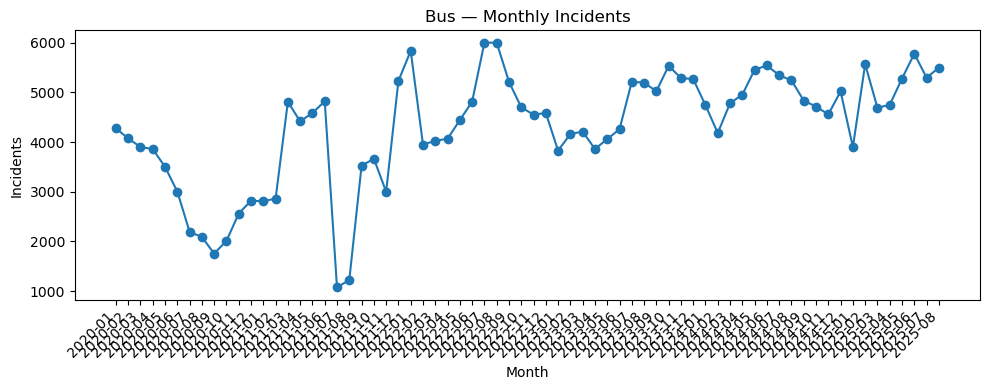

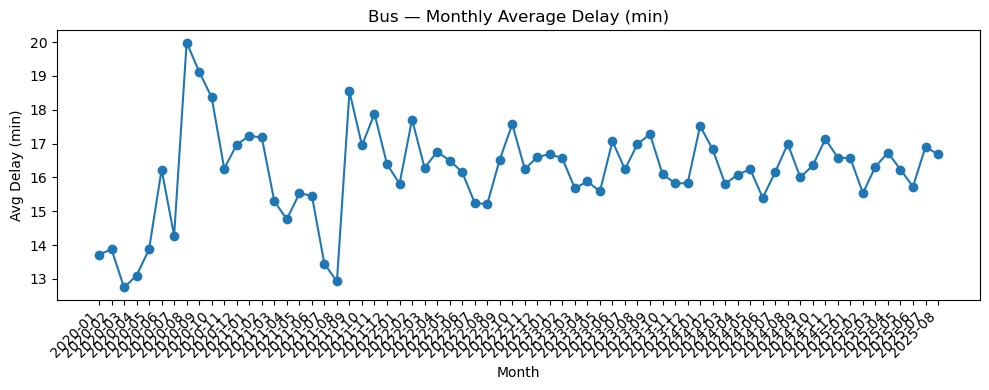

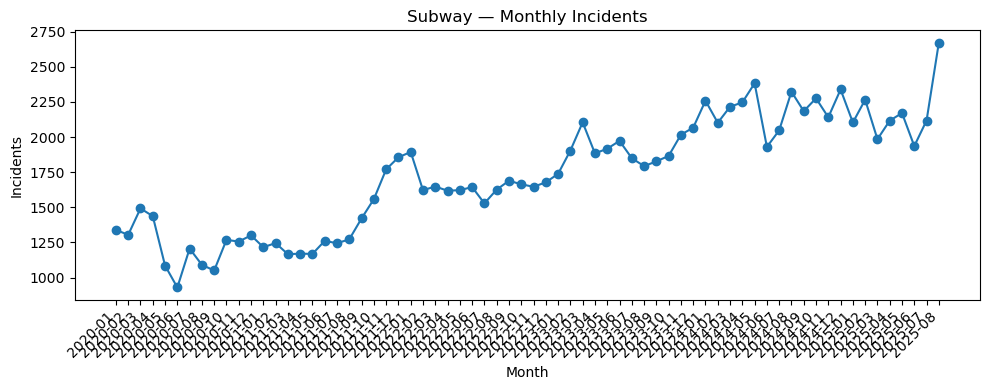

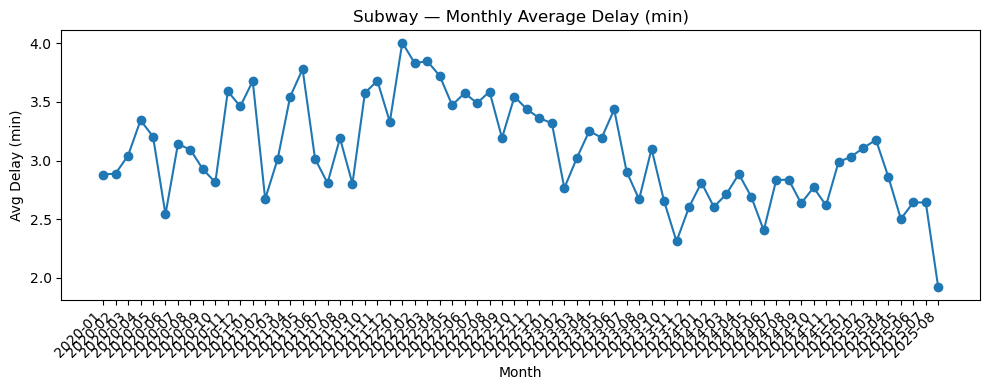

In [17]:
def monthly_trend(df, label):
    m = (df.groupby("month_year", as_index=False)
           .agg(incidents=("month_year","size"),
                avg_delay=("minutes_delay","mean")))
    m = m.sort_values("month_year")

    # Incidents trend
    plt.figure(figsize=(10,4))
    plt.plot(m["month_year"], m["incidents"], marker="o")
    plt.title(f"{label} — Monthly Incidents")
    plt.xlabel("Month")
    plt.ylabel("Incidents")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Avg delay trend
    plt.figure(figsize=(10,4))
    plt.plot(m["month_year"], m["avg_delay"], marker="o")
    plt.title(f"{label} — Monthly Average Delay (min)")
    plt.xlabel("Month")
    plt.ylabel("Avg Delay (min)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

monthly_trend(bus, "Bus")
monthly_trend(sub, "Subway")

2. Delay Distribution (Where is the mass and the tail?)

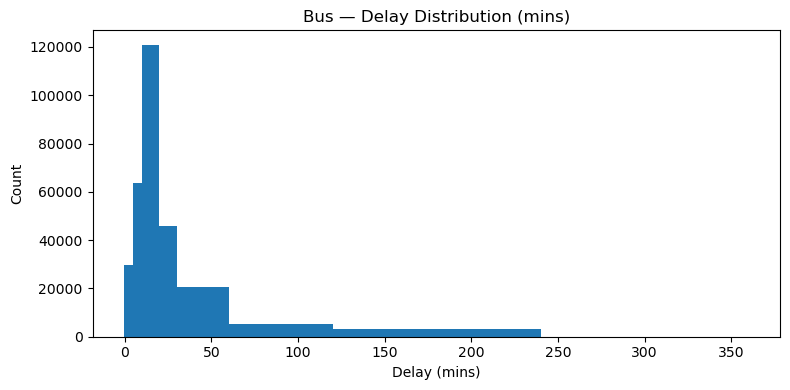

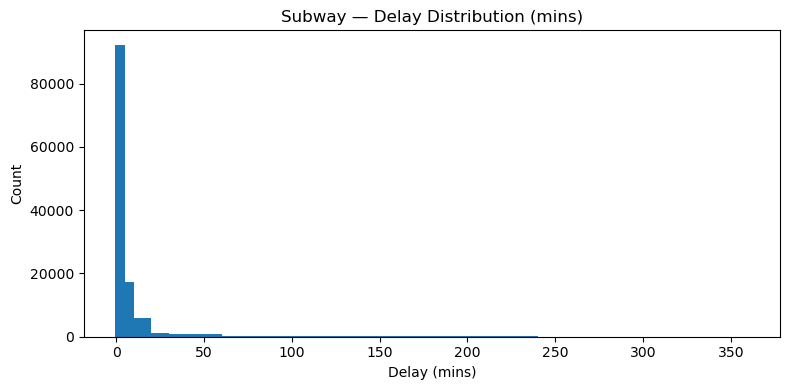

In [19]:
def delay_hist(df, label):
    data = df["minutes_delay"].dropna().values
    plt.figure(figsize=(8,4))
    # Fixed bins keep charts comparable
    bins = [-0.5, 5, 10, 20, 30, 60, 120, 240, 360]
    plt.hist(data, bins=bins)
    plt.title(f"{label} — Delay Distribution (mins)")
    plt.xlabel("Delay (mins)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

delay_hist(bus, "Bus")
delay_hist(sub, "Subway")

3. Temporal Patterns (When do delays spike?)

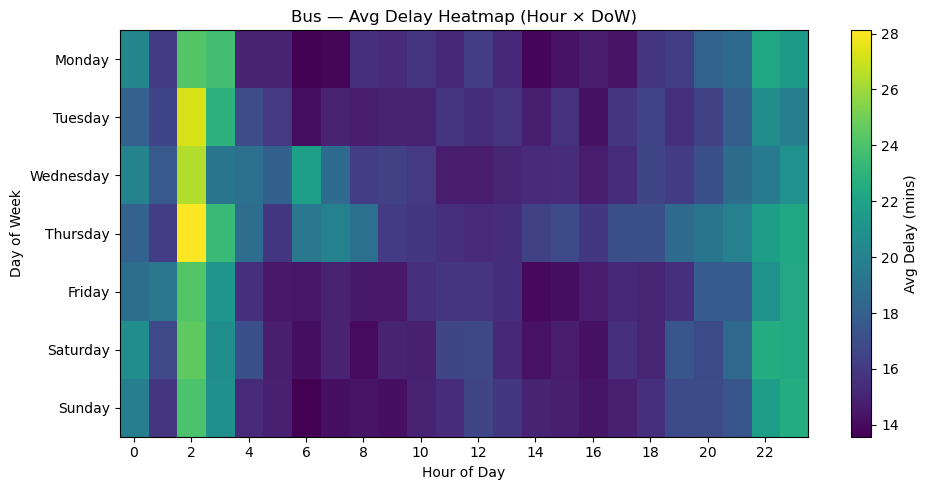

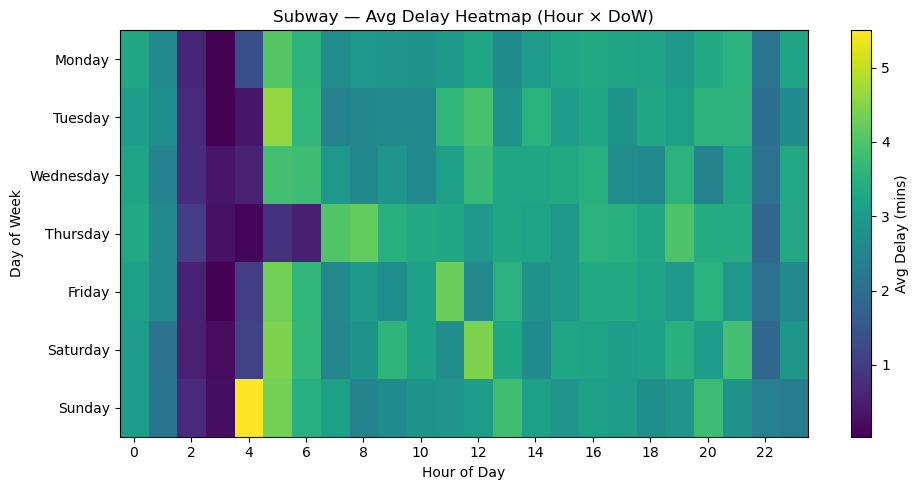

In [21]:
def hour_dow_heatmap(df, label, dow_col="dow_name"):
    # Order days
    dow_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    pivot = (df.groupby([dow_col,"hour"])
               .agg(avg_delay=("minutes_delay","mean"))
               .reset_index())
    # Ensure full grid 7×24
    idx = pd.MultiIndex.from_product([dow_order, range(24)], names=[dow_col,"hour"])
    pivot = pivot.set_index([dow_col,"hour"]).reindex(idx).reset_index()
    mat = pivot.pivot(index=dow_col, columns="hour", values="avg_delay").values

    plt.figure(figsize=(10,5))
    plt.imshow(mat, aspect="auto", interpolation="nearest")
    plt.title(f"{label} — Avg Delay Heatmap (Hour × DoW)")
    plt.xlabel("Hour of Day")
    plt.ylabel("Day of Week")
    plt.xticks(ticks=range(0,24,2), labels=[str(h) for h in range(0,24,2)])
    plt.yticks(ticks=range(7), labels=dow_order)
    plt.colorbar(label="Avg Delay (mins)")
    plt.tight_layout()
    plt.show()

hour_dow_heatmap(bus, "Bus")
hour_dow_heatmap(sub, "Subway")

4. Route/Line Ranking (Where to focus?)

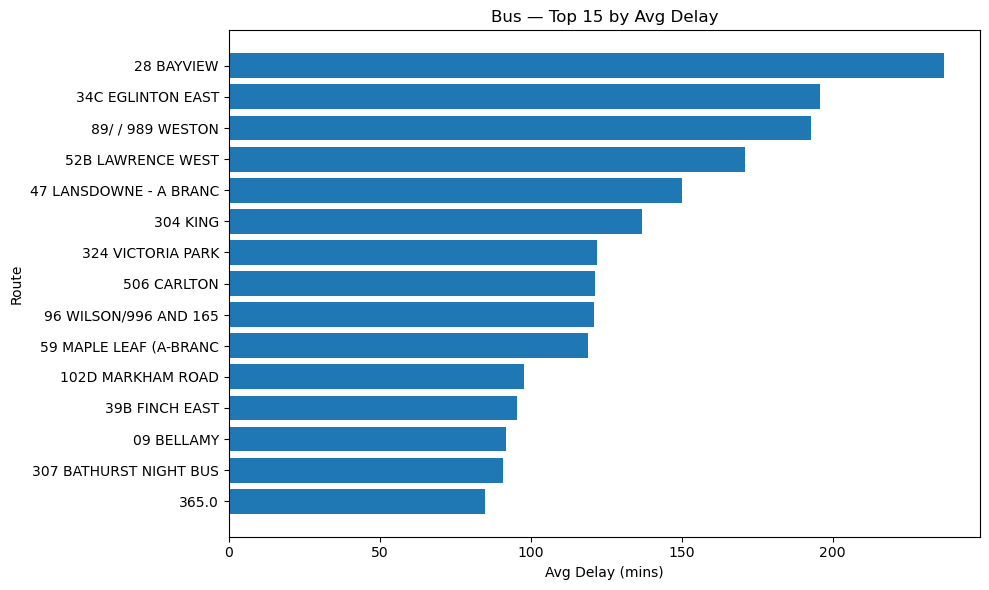

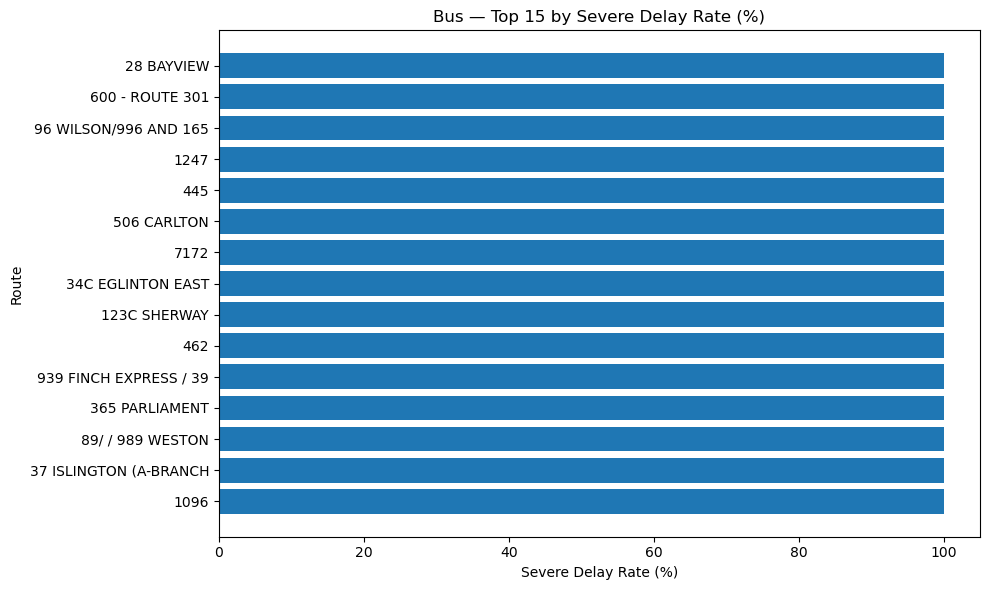

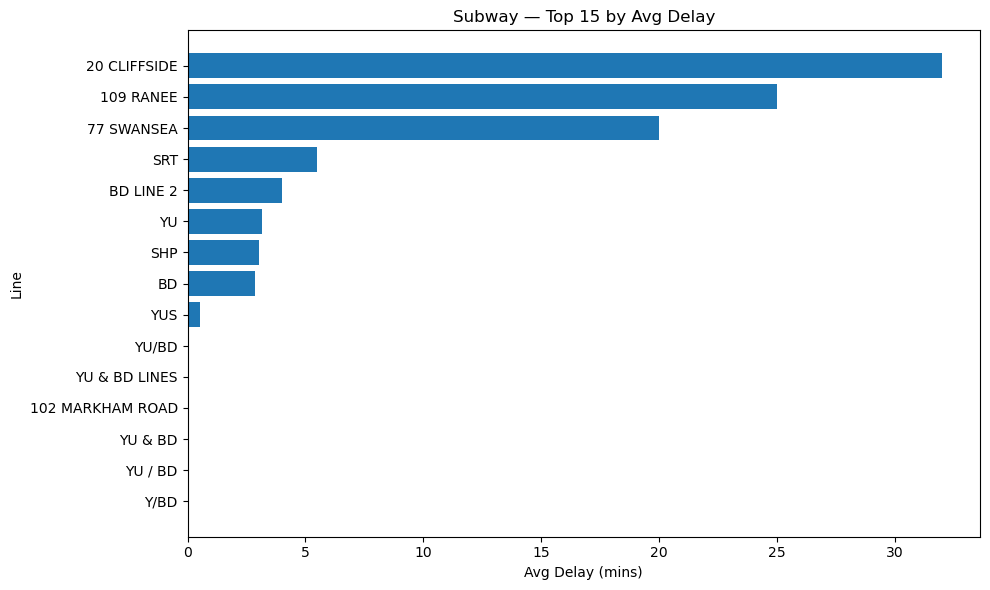

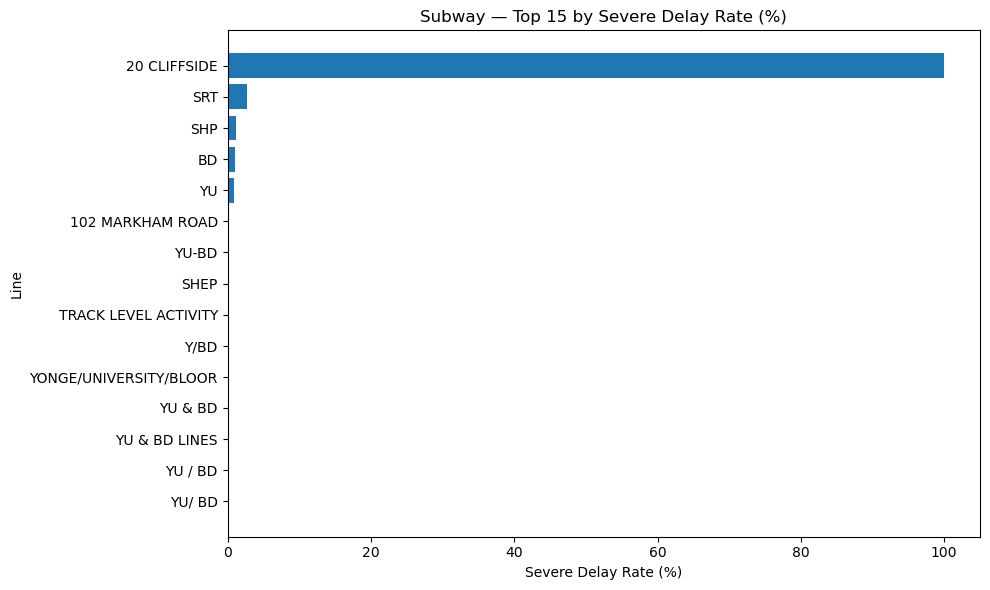

In [22]:
def top_routes(df, label, id_col):
    grouped = (df.groupby(id_col, as_index=False)
                 .agg(incidents=(id_col,"size"),
                      avg_delay=("minutes_delay","mean"),
                      severe_rate=("minutes_delay", lambda x: np.mean(x>=30) if x.notna().any() else np.nan))
                 .dropna(subset=[id_col]))
    top_avg = grouped.sort_values("avg_delay", ascending=False).head(15)
    top_sev = grouped.sort_values("severe_rate", ascending=False).head(15)

    # Avg delay
    plt.figure(figsize=(10,6))
    plt.barh(top_avg[id_col].astype(str), top_avg["avg_delay"])
    plt.gca().invert_yaxis()
    plt.title(f"{label} — Top {len(top_avg)} by Avg Delay")
    plt.xlabel("Avg Delay (mins)")
    plt.ylabel(id_col.title())
    plt.tight_layout()
    plt.show()

    # Severe rate
    plt.figure(figsize=(10,6))
    plt.barh(top_sev[id_col].astype(str), (top_sev["severe_rate"]*100))
    plt.gca().invert_yaxis()
    plt.title(f"{label} — Top {len(top_sev)} by Severe Delay Rate (%)")
    plt.xlabel("Severe Delay Rate (%)")
    plt.ylabel(id_col.title())
    plt.tight_layout()
    plt.show()

top_routes(bus, "Bus", id_col="route")
top_routes(sub, "Subway", id_col="line")

5. Hotspots Map (Where do delays cluster?)

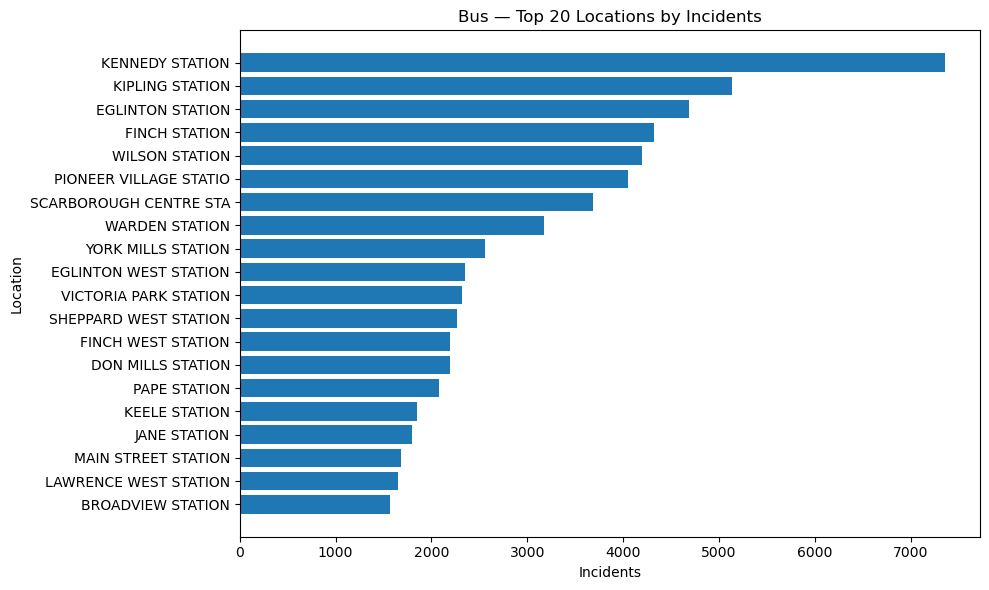

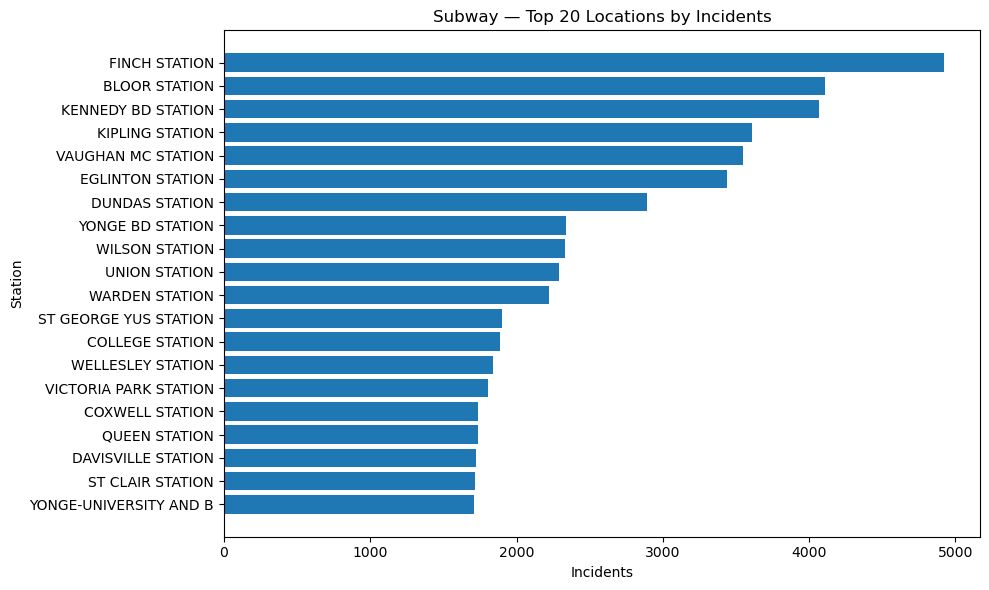

In [23]:
def top_places(df, label, place_col):
    grouped = (df.groupby(place_col, as_index=False)
                 .agg(incidents=(place_col,"size"),
                      avg_delay=("minutes_delay","mean"))
                 .dropna(subset=[place_col])
              ).sort_values("incidents", ascending=False).head(20)

    plt.figure(figsize=(10,6))
    plt.barh(grouped[place_col].astype(str), grouped["incidents"])
    plt.gca().invert_yaxis()
    plt.title(f"{label} — Top {len(grouped)} Locations by Incidents")
    plt.xlabel("Incidents")
    plt.ylabel(place_col.title())
    plt.tight_layout()
    plt.show()

top_places(bus, "Bus", place_col="location")
top_places(sub, "Subway", place_col="station")

6. Peak vs Off-Peak (When is service most fragile?)

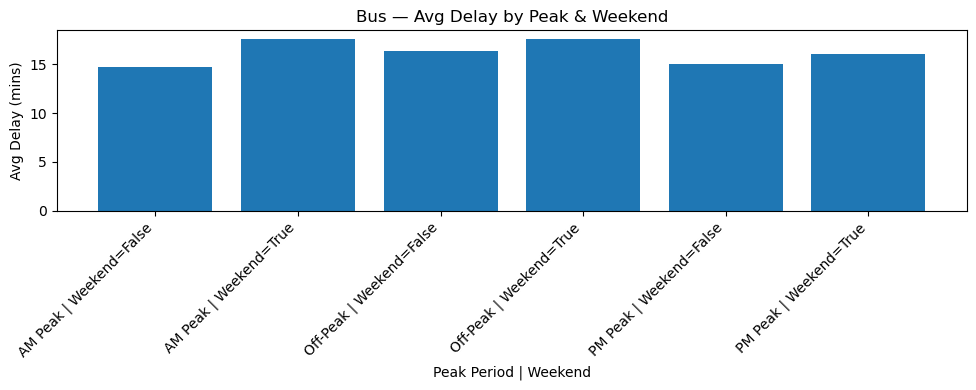

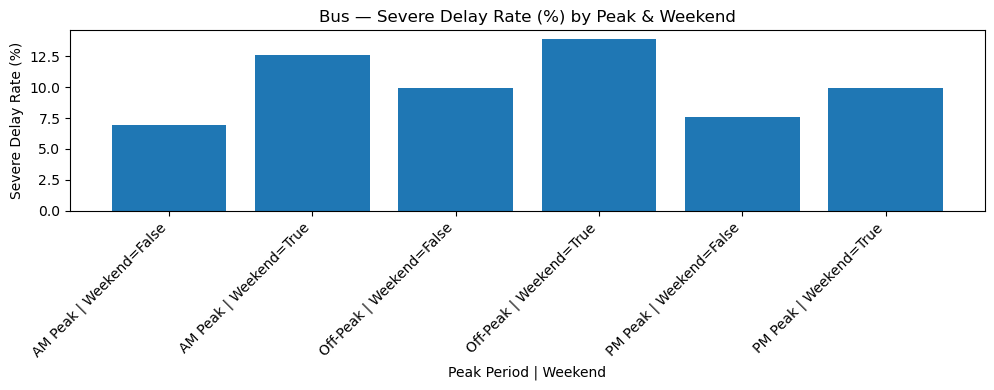

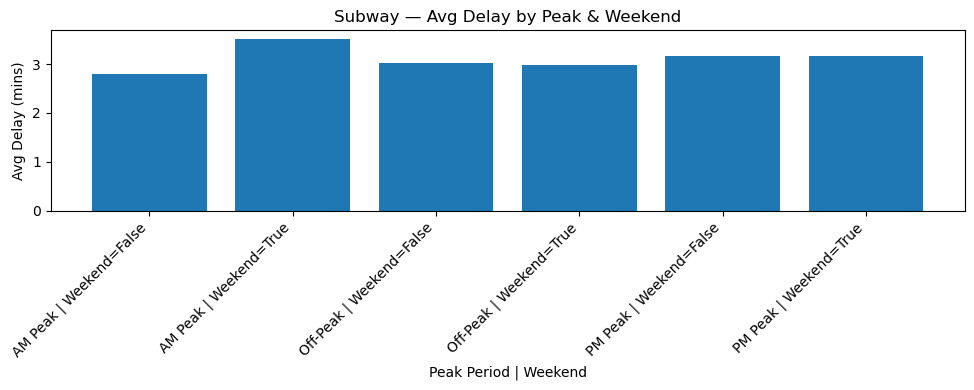

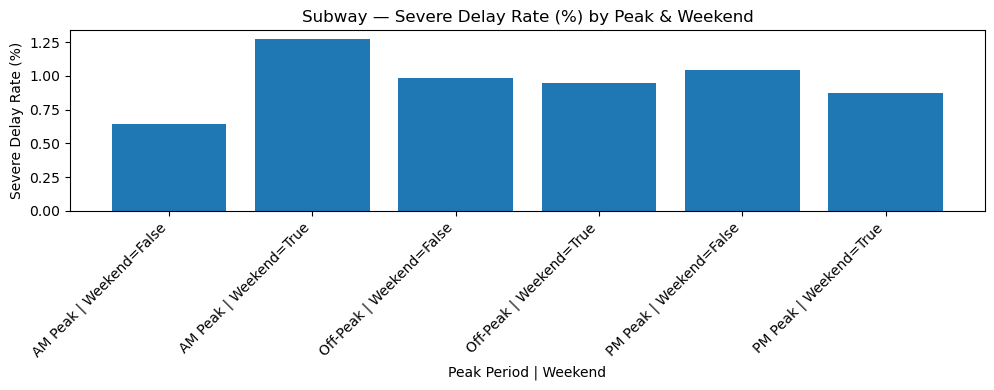

In [24]:
def peak_compare(df, label):
    g = (df.groupby(["peak_period","is_weekend"], as_index=False)
           .agg(avg_delay=("minutes_delay","mean"),
                severe_rate=("minutes_delay", lambda x: np.mean(x>=30) if x.notna().any() else np.nan)))
    g["label"] = g["peak_period"].astype(str) + " | Weekend=" + g["is_weekend"].astype(str)

    # Avg delay
    plt.figure(figsize=(10,4))
    plt.bar(g["label"], g["avg_delay"])
    plt.title(f"{label} — Avg Delay by Peak & Weekend")
    plt.xlabel("Peak Period | Weekend")
    plt.ylabel("Avg Delay (mins)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Severe rate
    plt.figure(figsize=(10,4))
    plt.bar(g["label"], g["severe_rate"]*100)
    plt.title(f"{label} — Severe Delay Rate (%) by Peak & Weekend")
    plt.xlabel("Peak Period | Weekend")
    plt.ylabel("Severe Delay Rate (%)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

peak_compare(bus, "Bus")
peak_compare(sub, "Subway")